In [1]:
"""
train the objective function, using interatomic distance distributions that are computed
from a dataset of known (
i.e., experimentally determined) 3D structures;
- plot the scoring profiles,
i.e. the score (or estimated Gibbs free energy) as a function of
the interatomic distance;
- use the objective function to evaluate predicted structures from the RNA-Puzzles
dataset
"""

'\ntrain the objective function, using interatomic distance distributions that are computed\nfrom a dataset of known (\ni.e., experimentally determined) 3D structures;\n- plot the scoring profiles,\ni.e. the score (or estimated Gibbs free energy) as a function of\nthe interatomic distance;\n- use the objective function to evaluate predicted structures from the RNA-Puzzles\ndataset\n'

In [ ]:
# Developing the objective(scoring) function based on known RNA 3D structures
import os
import sys
import argparse
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle
#from rdkit import Chem
#from rdkit.Chem import AllChem
#from rdkit.Chem import rdMolTransforms


In [7]:
from Bio.PDB import MMCIFParser, PDBParser

# create parser
MMCIFparser = MMCIFParser(QUIET=True)  # QUIET=True 
PDBparser = PDBParser(QUIET=True)

# read mmCIF or PDB file
#structure = MMCIFparser.get_structure("example", "./data/6e4o.cif")

#structure = PDBparser.get_structure("example", "./data/157d.pdb")

"""
# traverse structure
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                print(atom.get_name(), atom.get_coord())
"""

'\n# traverse structure\nfor model in structure:\n    for chain in model:\n        for residue in chain:\n            for atom in residue:\n                print(atom.get_name(), atom.get_coord())\n'

In [8]:
from rdkit import Chem

class Residue:
    def __init__(self, resname, resseq, atoms=None):
        self.resname = resname      # Residue name, e.g., 'ALA' or 'LIG' if exists
        self.resseq = resseq        # Residue sequence number
        self.atoms = atoms or {}    # {'C3': coord, ...}
        self.coarsed_atoms = {}  # {'C3': coord, ...} for coarse-grained atoms, C3 default

class Chain:
    def __init__(self, chain_id):
        self.chain_id = chain_id
        self.residues = []          # Residue object list

class Rna:
    def __init__(self, pdb_id):
        self.pdb_id = pdb_id
        self.chains = {}            # Chain object list

# RDKit
class Ligand:
    def __init__(self, mol_file):
        self.mol = Chem.MolFromMol2File(mol_file)  # RDKit Mol object

In [9]:
# traverse structure to classes
def load_structure(path):
    suffix = path.split('.')[1]
    if suffix == 'cif':
        structure = MMCIFparser.get_structure("example", path)
    else:
        structure = PDBparser.get_structure("example", path)
    for model in structure:
        rna = Rna(pdb_id="example")
        for chain in model:
            residues = Chain(chain_id=chain.id)
            for residue in chain:
                res = Residue(resname=residue.get_resname(), resseq=residue.get_id()[1])
                for atom in residue:
                    atom_name = atom.get_name()
                    #if atom_name == "C":
                    #    atom_name = "C3"
                    res.atoms[atom_name] = atom.get_coord()
                    residues.residues.append(res)
            rna.chains[chain.id] = residues
    return rna

In [40]:
"""
from Bio.PDB import MMCIFParser, PDBIO, Select

class LigandSelect(Select):
    def accept_residue(self, residue):
        # keep (HETATM), exclude water
        return residue.id[0] != " " and residue.resname != "HOH"

parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("example", "./data/6e4o.cif")

io = PDBIO()
io.set_structure(structure)
io.save("ligand_only.pdb", LigandSelect()) # extract ligands only
"""

'\nfrom Bio.PDB import MMCIFParser, PDBIO, Select\n\nclass LigandSelect(Select):\n    def accept_residue(self, residue):\n        # keep (HETATM), exclude water\n        return residue.id[0] != " " and residue.resname != "HOH"\n\nparser = MMCIFParser(QUIET=True)\nstructure = parser.get_structure("example", "./data/6e4o.cif")\n\nio = PDBIO()\nio.set_structure(structure)\nio.save("ligand_only.pdb", LigandSelect()) # extract ligands only\n'

In [38]:
"""
!obabel ligand_only.pdb -O ligand.sdf # generate sdf ligand file
"""

'\n!obabel ligand_only.pdb -O ligand.sdf # generate sdf ligand file\n'

In [8]:
from rdkit import Chem # ligands RDKit
ligand_mol = Chem.MolFromMolFile("ligand.sdf")

In [9]:
"""
for chain in rna.chains:
    for residue in rna.chains[chain].residues:
        if 'C3' in residue.atoms:
            print(residue.atoms['C3'])
"""

"\nfor chain in rna.chains:\n    for residue in rna.chains[chain].residues:\n        if 'C3' in residue.atoms:\n            print(residue.atoms['C3'])\n"

In [5]:
project_name = 'example'
## Prepare temp dir
import os
os.makedirs(f'./temp/{project_name}', exist_ok=True)
basepairs = ['AA','AU', 'AC', 'AG', 'UU', 'UC', 'UG', 'CC', 'CG', 'GG']


In [41]:
import requests

# query：Entity Type = RNA
query = {
    "query": {
        "type": "terminal",
        "service": "text",
        "parameters": {
            "attribute": "entity_poly.rcsb_entity_polymer_type",
            "operator": "exact_match",
            "value": "RNA"
        }
    },
    "return_type": "entry",
    "request_options": {
        "return_all_hits": True
    }
}

url = "https://search.rcsb.org/rcsbsearch/v2/query"
r = requests.post(url, json=query)
data = r.json()

# extract PDB id
pdb_ids = [res['identifier'] for res in data['result_set']]
print(f"{len(pdb_ids)} RNA PDB entries found")
print(pdb_ids[:10]) 


9251 RNA PDB entries found
['124D', '157D', '165D', '176D', '17RA', '1A1T', '1A34', '1A3M', '1A4D', '1A4T']


In [42]:
import os
import requests

""" Download the first 50 PDB files for demonstration 
# configure, only download first 50 PDBs for demo
pdb_ids_to_download = pdb_ids[:50]

save_dir = "./data"  # Save directory
os.makedirs(save_dir, exist_ok=True)

# Download function
def download_pdb(pdb_id, save_dir):
        # Download a single PDB file
    pdb_id = pdb_id.lower()
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    local_path = os.path.join(save_dir, f"{pdb_id}.pdb")
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(local_path, "w") as f:
            f.write(response.text)
        print(f"Successfully downloaded: {pdb_id}.pdb")
    except Exception as e:
        print(f"Failed to download: {pdb_id}.pdb  -> {e}")

# Batch download
#for pdb_id in pdb_ids_to_download:
#    download_pdb(pdb_id, save_dir)
"""

' Download the first 50 PDB files for demonstration \n# configure, only download first 50 PDBs for demo\npdb_ids_to_download = pdb_ids[:50]\n\nsave_dir = "./data"  # Save directory\nos.makedirs(save_dir, exist_ok=True)\n\n# Download function\ndef download_pdb(pdb_id, save_dir):\n        # Download a single PDB file\n    pdb_id = pdb_id.lower()\n    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"\n    local_path = os.path.join(save_dir, f"{pdb_id}.pdb")\n    \n    try:\n        response = requests.get(url)\n        response.raise_for_status()  # Raise an exception for HTTP errors\n        with open(local_path, "w") as f:\n            f.write(response.text)\n        print(f"Successfully downloaded: {pdb_id}.pdb")\n    except Exception as e:\n        print(f"Failed to download: {pdb_id}.pdb  -> {e}")\n\n# Batch download\n#for pdb_id in pdb_ids_to_download:\n#    download_pdb(pdb_id, save_dir)\n'

In [2]:
#compute the observed frequencies: 10 × 20 distances intervals (0 to 20 Å)
from tqdm import tqdm
def compute_observed_frequencies(rna_structures, bins=20):
    """
    compute observed frequencies of interatomic distances for basepairs
    rna_structures: list of Rna objects
    bins: number of distance intervals, e.g., 20
    """
    frequency_counts = {}
    basepairs = ['AA','AU', 'AC', 'AG', 'UU', 'UC', 'UG', 'CC', 'CG', 'GG']
    for bp in basepairs:
        frequency_counts[bp] = np.zeros(bins)
    for rna in tqdm(rna_structures):
        for chain in rna.chains.values():
            for res1 in chain.residues:
                i = res1.resseq
                for res2 in chain.residues:
                    j = res2.resseq
                    if abs(i - j) < 4 or i > j:
                        continue  # distance only for residues with |i-j|>3
                    base1 = res1.resname
                    base2 = res2.resname
                    if base1 + base2 not in basepairs and base2 + base1 not in basepairs:
                        continue  # only consider standard basepairs
                    basepair_id = basepairs.index(base1 + base2) if (base1 + base2) in basepairs else basepairs.index(base2 + base1)
                    bp = basepairs[basepair_id]
                    if "C3'" in res1.atoms and "C3'" in res2.atoms:
                        coord1 = res1.atoms["C3'"]
                        coord2 = res2.atoms["C3'"]
                        distance = np.linalg.norm(coord1 - coord2)
                        bin_index = np.digitize(distance, np.linspace(0, 20, bins + 1)) - 1
                        if 0 <= bin_index < len(frequency_counts[bp]):
                            frequency_counts[bp][bin_index] += 1
    frequencies = {}
    for bp in basepairs:
        frequencies[bp] = frequency_counts[bp] / np.sum(frequency_counts[bp]) if np.sum(frequency_counts[bp]) > 0 else frequency_counts[bp]
    return frequencies

In [10]:
# all libraries reference frequency
import numpy as np
lib_rna = []
ref_frequencies = {}
for bp in basepairs:
    ref_frequencies[bp] = np.zeros(20)
lib_files = os.listdir('./data/')
for lib_file in lib_files:
    if lib_file.endswith('.pdb'):
        rna = load_structure(f'./data/{lib_file}')
        lib_rna.append(rna)
#ref_frequencies = compute_observed_frequencies(lib_rna, bins=20)

In [11]:
import pickle
#pickle.dump(ref_frequencies, open('./ref_frequencies.pkl', 'wb'))
ref_frequencies = pickle.load(open('./ref_frequencies.pkl', 'rb'))

In [8]:
# -- mp
"""
import multiprocessing
def worker(rna, bins):
    return compute_observed_frequencies([rna], bins)
def compute_observed_frequencies_mp(rna_structures, bins, num_processes):
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.starmap(worker, [(rna, bins) for rna in rna_structures])
    # aggregate results
    return results
mp_ref_frequencies = compute_observed_frequencies_mp(lib_rna, bins=20, num_processes=4)
"""

'\nimport multiprocessing\ndef worker(rna, bins):\n    return compute_observed_frequencies([rna], bins)\ndef compute_observed_frequencies_mp(rna_structures, bins, num_processes):\n    with multiprocessing.Pool(processes=num_processes) as pool:\n        results = pool.starmap(worker, [(rna, bins) for rna in rna_structures])\n    # aggregate results\n    return results\nmp_ref_frequencies = compute_observed_frequencies_mp(lib_rna, bins=20, num_processes=4)\n'

In [12]:
obs_frequency = compute_observed_frequencies([lib_rna[40]], bins=20)
bins = 20
### log-ratio
def pseudo_energy(obs_frequency, ref_frequencies, basepairs, bins = 20):
    pseudoE = {}
    for bp in basepairs:
        ratio_list = []
        for i in range(bins):
            ratio = -np.log(obs_frequency[bp][i] / (ref_frequencies[bp][i] + 1e-8))
            ratio_list.append(ratio if np.isfinite(ratio) else 10)
        pseudoE[bp] = np.array(ratio_list)
    return pseudoE
pseudoE = pseudo_energy(obs_frequency, ref_frequencies, basepairs, bins=20)
"""
pseudoE = {}
for bp in basepairs:
    ratio_list = []
    for i in range(bins):
        ratio = -np.log(obs_frequency[bp][i] / (ref_frequencies[bp][i] + 1e-8))
        ratio_list.append(ratio if np.isfinite(ratio) else 10)
    pseudoE[bp] = np.array(ratio_list)
    # add small value to avoid log(0)
"""
#pseudoE

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.46s/it]
C:\Users\dence\AppData\Local\Temp\ipykernel_93984\1746291213.py:9: RuntimeWarning: divide by zero encountered in log
  ratio = -np.log(obs_frequency[bp][i] / (ref_frequencies[bp][i] + 1e-8))


'\npseudoE = {}\nfor bp in basepairs:\n    ratio_list = []\n    for i in range(bins):\n        ratio = -np.log(obs_frequency[bp][i] / (ref_frequencies[bp][i] + 1e-8))\n        ratio_list.append(ratio if np.isfinite(ratio) else 10)\n    pseudoE[bp] = np.array(ratio_list)\n    # add small value to avoid log(0)\n'

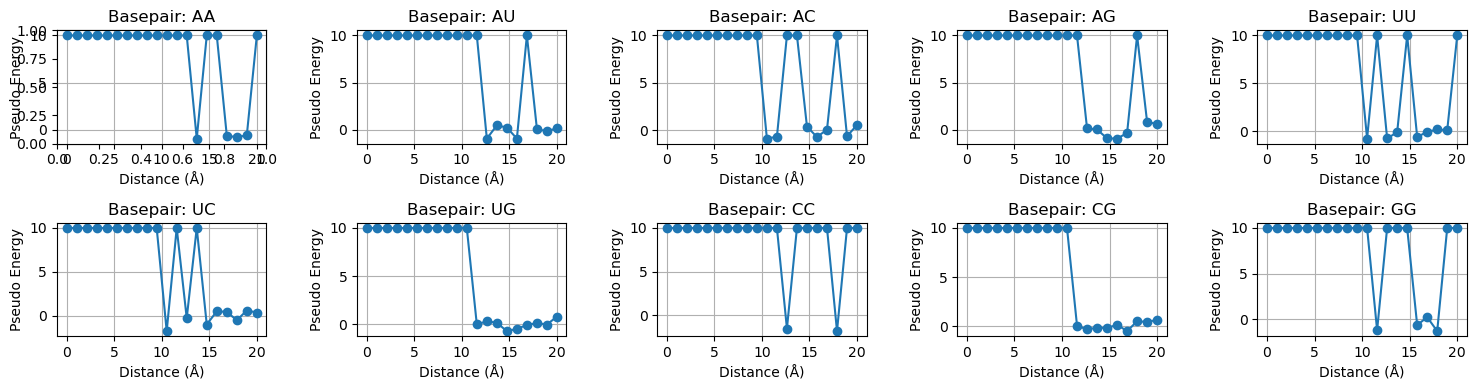

In [14]:
from matplotlib import pyplot as plt
def plot_scoring_profiles(pseudoE, bins=20):
    """
    Plot scoring profiles for each basepair
    pseudoE: dict of pseudo energies for each basepair
    bins: number of distance intervals
    """
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(2, 5, 1)
    for pltx in range(2):
        for plty in range(5):
            ax = plt.subplot2grid((2, 5), (pltx, plty))
            bp = basepairs[pltx * 5 + plty]
            ax.plot(np.linspace(0, bins, bins), pseudoE[bp], marker='o')
            ax.set_title(f'Basepair: {bp}')
            ax.set_xlabel('Distance (Å)')
            ax.set_ylabel('Pseudo Energy')
            ax.grid()
    plt.tight_layout()
plot_scoring_profiles(pseudoE, bins=20)
    

In [35]:
def save_scoreprofile(score, folder):
    for bp in basepairs:
        with open(os.path.join(folder, bp), 'w') as f:
            for i in score[bp]:
                f.write(f"{i}\n")
#save_scoreprofile(pseudoE, './temp/example/')

In [36]:
def linear_interpolation(scoreprofile, distance, bp):
    """
    Linear interpolation of score at given distance
    score: dict of pseudo energies for each basepair
    distance: float, interatomic distance
    """
    bin_size = 20 / len(next(iter(scoreprofile.values())))
    bin_index = int(distance // bin_size)
    if bin_index >= len(next(iter(scoreprofile.values()))) - 1:
        return scoreprofile[bp][-1]
    fraction = (distance - bin_index * bin_size) / bin_size
    interpolated_score = scoreprofile[bp][bin_index] + fraction * (scoreprofile[bp][bin_index + 1] - scoreprofile[bp][bin_index])
    return interpolated_score

In [37]:
def overall_score(rna_structure, scoreprofile):
    """
    Compute overall score for an RNA structure
    rna_structure: Rna object
    scoreprofile: dict of pseudo energies for each basepair
    """
    total_score = 0.0
    for chain in rna_structure.chains.values():
        for res1 in chain.residues:
            i = res1.resseq
            for res2 in chain.residues:
                j = res2.resseq
                if abs(i - j) < 4 or i > j:
                    continue  # distance only for residues with |i-j|>3
                base1 = res1.resname
                base2 = res2.resname
                if base1 + base2 not in basepairs and base2 + base1 not in basepairs:
                    continue  # only consider standard basepairs
                bp = base1 + base2 if (base1 + base2) in basepairs else base2 + base1
                if "C3'" in res1.atoms and "C3'" in res2.atoms:
                    coord1 = res1.atoms["C3'"]
                    coord2 = res2.atoms["C3'"]
                    distance = np.linalg.norm(coord1 - coord2)
                    score = linear_interpolation(scoreprofile, distance, bp)
                    total_score += score
    return total_score
overall_score(lib_rna[0], pseudoE)

np.float64(24211.41324589165)